In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
import math
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import inf
from sklearn.model_selection import GridSearchCV



In [10]:
# Load the train and test datasets
Xtrain_scaled = np.load('Xtrain_scaled.npy')
Xtest_scaled = np.load('Xtest_scaled.npy')
Xtrainb_scaled = np.load('Xtrainb_scaled.npy')
Xtestb_scaled = np.load('Xtestb_scaled.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')
df_train = pd.read_csv('../paths_CYF_trainData.csv')
df_test = pd.read_csv('../paths_CYF_testData.csv')


In [11]:
# Initial variables for the model. 
# I focus exclusively on the pre services and loc plus demographics with less than 20% of missing data.

id_cols = ['id', 'client_id']

demo_cols = ['age', 'age_group','race','gender','dx_group','lang', 'substance','insurance','liv']

ip_cols = ['as_loc', 'as_length_IP', 'IP_history', 'as_close']

loc_pre_cols = ['loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre']

svc_total_pre_cols = ['svc_pre_all', 'svc_pre', 'svc_pre_sub']

svc_CYF_timepoint_pre_cols = ['svc_op_7days_pre', 'svc_op_30days_pre', 'svc_op_60days_pre', 'svc_op_90days_pre',
                     'svc_es_7days_pre', 'svc_es_30days_pre', 'svc_es_60days_pre', 'svc_es_90days_pre',
                     'svc_dt_7days_pre', 'svc_dt_30days_pre', 'svc_dt_60days_pre', 'svc_dt_90days_pre',
                     'svc_ip_7days_pre', 'svc_ip_30days_pre', 'svc_ip_60days_pre', 'svc_ip_90days_pre']

output_col = ['svc_CYF_ip_90days_postdc_bi']

drop_cols = ['']

In [12]:
numerical_features = ['age', 'as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']
numerical_features = numerical_features  + svc_CYF_timepoint_pre_cols
dummy_vars = df_train.loc[:, 'age_group_12-15 Yrs':'loc5_pre_WRAP']
dummy_vars = list(dummy_vars.columns)
categorical_features = dummy_vars + ['substance', 'new','CWS', 'ADS', 'JJ']
all_features = numerical_features + categorical_features

boruta_features = ['as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_op_30days_pre', 'svc_es_30days_pre', 'svc_ip_7days_pre', 'svc_ip_30days_pre', 'as_loc_IPCAPS', 'as_loc_IPFFS', 'as_close_Home/Shelter/Self', 'loc2_pre_None']

In [13]:
Xtrain = df_train[all_features]
Xtrainb = df_train[boruta_features]

In [14]:
# Set a seed for reproducibility
SEED = 300
np.random.seed(SEED)

In [15]:
print(np.any(np.isnan(Xtrain_scaled)))
print(np.any(np.isnan(ytrain)))
#np.all(np.isfinite(Xtrain_scaled))

False
False


In [16]:
print(np.any(np.isnan(Xtest_scaled)))
print(np.any(np.isnan(ytest)))

False
False


### Fit all variables into the models

In [17]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# import model metrics
from sklearn.metrics import *


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    
    models = {'naive bayes': nb,
              'knn': knn,
              'logistic': lr,
              'mlp-nn': nn,
              'decision tree': dt,
              'random forest': rf,
              'gbm': gb
             }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    S = np.zeros((ytest.shape[0], len(model_list)))
    S = pd.DataFrame(S)
    
    print("Fitting models.")
    cols = list()
    model_cvs = {}

    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        model_cvs[name] = m.fit(xtrain, ytrain)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        S.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    S.columns = cols
    
    print("Done.\n")
    return P, S, model_cvs

    
def evaluate(y_true, S, P):
    for m in P.columns:
        y_pred = S.loc[:, m]
        y_pred_proba = P.loc[:, m]
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1score = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
        print ("Accuracy : {:.4f}".format(acc))
        print("Precision : {:.4f}".format(precision))
        print("Recall : {:.4f}".format(recall))
        print("F1 score : {:.4f}".format(f1score))
        print("AUC score : {:.4f}".format(auc))
        print("AP score : {:.4f}".format(ap))
        print("\nClassification report : \n", classification_report(y_true, y_pred))
        print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
        print("done.\n")  
    return acc, precision, recall, f1score, auc, ap

In [18]:
models = get_models()
P, S, model_cvs = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
evaluate(ytest, S, P)

Fitting models.
naive bayes... Time elapsed  0:00:00.167005
done
knn... Time elapsed  5:38:35.006368
done
logistic... Time elapsed  0:00:01.210999
done
mlp-nn... Time elapsed  0:00:33.221000
done
decision tree... Time elapsed  0:00:01.548002
done
random forest... Time elapsed  0:00:08.179005
done
gbm... Time elapsed  0:00:35.525993
done
Done.

Accuracy : 0.6597
Precision : 0.6854
Recall : 0.2633
F1 score : 0.3805
AUC score : 0.6956
AP score : 0.5900

Classification report : 
               precision    recall  f1-score   support

           0       0.66      0.92      0.77      1686
           1       0.69      0.26      0.38      1109

    accuracy                           0.66      2795
   macro avg       0.67      0.59      0.57      2795
weighted avg       0.67      0.66      0.61      2795


Confusion matrix : 
 [[1552  134]
 [ 817  292]]
done.

Accuracy : 0.6519
Precision : 0.5495
Recall : 0.6808
F1 score : 0.6081
AUC score : 0.6984
AP score : 0.5503

Classification report : 
  

(0.7477638640429338,
 0.704868154158215,
 0.6266907123534716,
 0.6634844868735084,
 0.8127530386025263,
 0.7624249594967306)

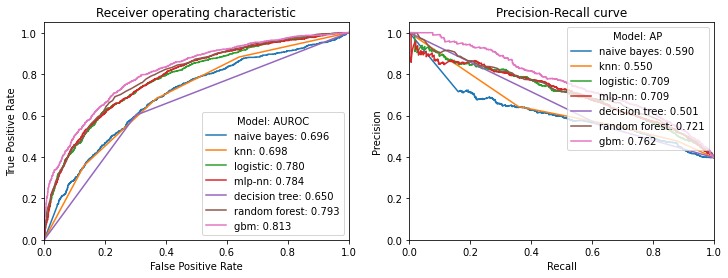

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in P.columns:
    roc_auc = roc_auc_score(ytest, P[column])
    fpr, tpr, _ = roc_curve(ytest, P[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, P[column])
    ave_prec_rec = average_precision_score(ytest, P[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

In [20]:
lr_importances = pd.Series(model_cvs['logistic'].coef_[0], index=Xtrain.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvs['logistic'].coef_[0]), index=Xtrain.columns, name = 'LR')
print("Top 15 features")
print(lr_importances.nlargest(15))

Top 15 features
svc_ip_60days_pre                   2.668672
svc_ip_90days_pre                   2.477471
IP_history                          2.053283
svc_ip_30days_pre                   1.658656
loc5_pre_CR                         1.577583
as_close_Psychiatric Hospital       1.518364
svc_es_90days_pre                   1.468350
dx_group_Other/ Excluded            0.966001
loc1_pre_CM                         0.854964
loc2_pre_DTCTF                      0.809817
dx_group_Schizophrenic Disorders    0.802817
as_close_Unknown                    0.768030
as_close_Medical Hospital           0.754779
loc5_pre_PREV                       0.742491
svc_dt_30days_pre                   0.725448
Name: LR, dtype: float64


In [21]:
dt_importances = pd.Series(model_cvs['decision tree'].feature_importances_, index=Xtrain.columns, name = 'DT')
print("Top 15 features")
print(dt_importances.nlargest(15))

Top 15 features
IP_history           0.151489
as_length_IP         0.129877
svc_pre_all          0.049380
svc_ip_60days_pre    0.044546
age                  0.038225
svc_pre              0.032116
as_loc_IPFFS         0.028677
svc_es_90days_pre    0.028606
svc_op_90days_pre    0.026964
svc_op_60days_pre    0.025426
svc_op_30days_pre    0.024046
svc_op_7days_pre     0.020144
svc_ip_7days_pre     0.017032
as_loc_IPCAPS        0.015486
svc_es_30days_pre    0.014448
Name: DT, dtype: float64


In [22]:
rf_importances = pd.Series(model_cvs['random forest'].feature_importances_, index=Xtrain.columns, name = 'RF')
print("Top 15 features")
print(rf_importances.nlargest(15))

Top 15 features
as_length_IP         0.078702
IP_history           0.058355
svc_pre_all          0.042175
age                  0.037652
svc_pre              0.037272
svc_ip_90days_pre    0.037077
svc_op_90days_pre    0.033296
svc_op_60days_pre    0.030365
svc_es_90days_pre    0.027819
svc_op_30days_pre    0.027233
svc_es_60days_pre    0.026638
svc_ip_60days_pre    0.024895
as_loc_IPFFS         0.024767
svc_ip_30days_pre    0.023544
svc_op_7days_pre     0.023316
Name: RF, dtype: float64


In [23]:
gbm_importances = pd.Series(model_cvs['gbm'].feature_importances_, index=Xtrain.columns, name = 'GBM')
print("Top 15 features")
print(gbm_importances.nlargest(15))

Top 15 features
IP_history                    0.320899
as_length_IP                  0.165567
svc_ip_90days_pre             0.093611
as_loc_IPFFS                  0.080643
as_loc_IPCAPS                 0.051938
svc_ip_60days_pre             0.041282
age                           0.031794
svc_ip_7days_pre              0.025058
as_close_Home/Shelter/Self    0.019683
svc_es_90days_pre             0.019099
svc_pre_sub                   0.014231
svc_op_90days_pre             0.012528
svc_es_60days_pre             0.011830
svc_op_7days_pre              0.011744
liv_House or Apartment        0.010152
Name: GBM, dtype: float64


In [24]:
importances_df = pd.concat([lr_importances, dt_importances, rf_importances, gbm_importances], axis=1)
importances_df['avg'] = importances_df[['DT', 'RF', 'GBM']].mean(axis=1)
importances_df = importances_df.sort_values(by='avg', ascending=False)
importances_df.reset_index(inplace=True)
importances_df = importances_df.rename(columns = {'index':'Variable'})
importances_df.head(15)

,Variable,LR,DT,RF,GBM,avg
0,IP_history,2.053283,0.151489,0.058355,0.320899,0.176915
1,as_length_IP,-0.401236,0.129877,0.078702,0.165567,0.124715
2,svc_ip_90days_pre,2.477471,0.008337,0.037077,0.093611,0.046342
3,as_loc_IPFFS,-2.269884,0.028677,0.024767,0.080643,0.044695
4,svc_ip_60days_pre,2.668672,0.044546,0.024895,0.041282,0.036908
5,age,-0.592695,0.038225,0.037652,0.031794,0.035890
6,svc_pre_all,0.084994,0.049380,0.042175,0.000335,0.030630
7,as_loc_IPCAPS,-2.042154,0.015486,0.017378,0.051938,0.028268
8,svc_es_90days_pre,1.468350,0.028606,0.027819,0.019099,0.025175
9,svc_op_90days_pre,0.525020,0.026964,0.033296,0.012528,0.024263


In [25]:
# Select the top 15 variables
important_vars = list(importances_df.iloc[0:15,0])
important_vars

['IP_history',
 'as_length_IP',
 'svc_ip_90days_pre',
 'as_loc_IPFFS',
 'svc_ip_60days_pre',
 'age',
 'svc_pre_all',
 'as_loc_IPCAPS',
 'svc_es_90days_pre',
 'svc_op_90days_pre',
 'svc_pre',
 'svc_op_60days_pre',
 'svc_op_30days_pre',
 'svc_op_7days_pre',
 'svc_ip_7days_pre']

### Fit Boruta-select variables into the models

In [26]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
evaluate(ytest, Sb, Pb)

Fitting models.
naive bayes... Time elapsed  0:00:00.024997
done
knn... Time elapsed  0:00:00.815002
done
logistic... Time elapsed  0:00:00.081995
done
mlp-nn... Time elapsed  0:00:06.128002
done
decision tree... Time elapsed  0:00:00.215001
done
random forest... Time elapsed  0:00:03.702001
done
gbm... Time elapsed  0:00:03.507006
done
Done.

Accuracy : 0.6769
Precision : 0.6247
Recall : 0.4653
F1 score : 0.5333
AUC score : 0.7269
AP score : 0.6305

Classification report : 
               precision    recall  f1-score   support

           0       0.70      0.82      0.75      1686
           1       0.62      0.47      0.53      1109

    accuracy                           0.68      2795
   macro avg       0.66      0.64      0.64      2795
weighted avg       0.67      0.68      0.67      2795


Confusion matrix : 
 [[1376  310]
 [ 593  516]]
done.

Accuracy : 0.6597
Precision : 0.5636
Recall : 0.6312
F1 score : 0.5955
AUC score : 0.6994
AP score : 0.5646

Classification report : 
  

(0.7341681574239713,
 0.6654611211573237,
 0.6636609558160504,
 0.6645598194130925,
 0.8017969016576335,
 0.755379450347563)

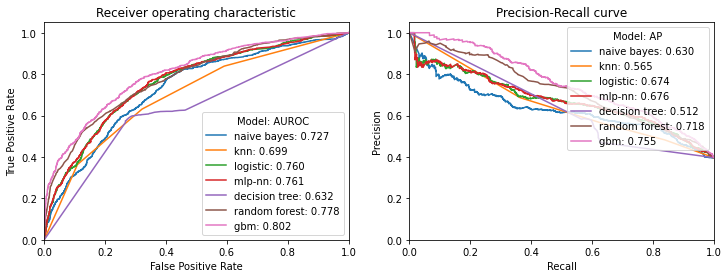

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pb.columns:
    roc_auc = roc_auc_score(ytest, Pb[column])
    fpr, tpr, _ = roc_curve(ytest, Pb[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pb[column])
    ave_prec_rec = average_precision_score(ytest, Pb[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

### Fit important variables into the models

In [28]:
Xtrain2 = df_train[important_vars]
Xtest2 = df_test[important_vars]
ytrain_original = df_train['svc_CYF_ip_90days_postdc_bi']


In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain2_scaled = scaler.fit_transform(Xtrain2)
Xtest2_scaled = scaler.fit_transform(Xtest2)

In [30]:
# Class Imbalance Processing: Using re-sampling method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
Xtrain2_scaled, ytrain = sm.fit_sample(Xtrain2_scaled, ytrain_original)

In [31]:
models = get_models()
Pm, Sm, model_cvsm = train_predict(models, Xtrain2_scaled, ytrain, Xtest2_scaled)
evaluate(ytest, Sm, Pm)

Fitting models.
naive bayes... Time elapsed  0:00:00.020998
done
knn... Time elapsed  0:00:00.866001
done
logistic... Time elapsed  0:00:00.078000
done
mlp-nn... Time elapsed  0:00:06.523004
done
decision tree... Time elapsed  0:00:00.259005
done
random forest... Time elapsed  0:00:04.303994
done
gbm... Time elapsed  0:00:04.908008
done
Done.

Accuracy : 0.6844
Precision : 0.6495
Recall : 0.4445
F1 score : 0.5278
AUC score : 0.6900
AP score : 0.6187

Classification report : 
               precision    recall  f1-score   support

           0       0.70      0.84      0.76      1686
           1       0.65      0.44      0.53      1109

    accuracy                           0.68      2795
   macro avg       0.67      0.64      0.65      2795
weighted avg       0.68      0.68      0.67      2795


Confusion matrix : 
 [[1420  266]
 [ 616  493]]
done.

Accuracy : 0.6125
Precision : 0.5089
Recall : 0.6682
F1 score : 0.5778
AUC score : 0.6668
AP score : 0.5280

Classification report : 
  

(0.5230769230769231,
 0.4501779359430605,
 0.9125338142470695,
 0.60291927316056,
 0.7442645474800698,
 0.6989904641692695)

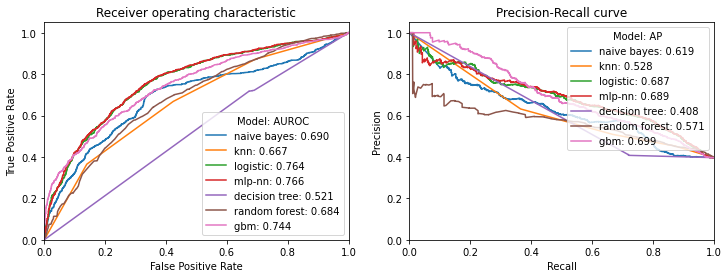

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pm.columns:
    roc_auc = roc_auc_score(ytest, Pm[column])
    fpr, tpr, _ = roc_curve(ytest, Pm[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pm[column])
    ave_prec_rec = average_precision_score(ytest, Pm[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

From the above results, I selected Gradient Boosting as my main model and the set of variables from the Boruta algorithms

## GBM tuning

In [33]:
param1 = {
    "n_estimators":[100,500,1000,1500],
    "learning_rate":[1, 0.1, 0.01, 0.001]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param1, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)


C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=300,
                                                  subsample=1),
             iid=False, n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='accuracy')

In [34]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.1, 'n_estimators': 1000}, 0.7369868872876666)

In [35]:
param2 = {
   'max_depth':[2,3,4,5,6,7]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1000, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param2, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)
tuning.best_params_, tuning.best_score_

C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'max_depth': 7}, 0.7371335223553152)

In [36]:
new=GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=7, max_features='sqrt' , random_state=SEED)
new.fit(Xtrainb_scaled,ytrain)


GradientBoostingClassifier(max_depth=7, max_features='sqrt', n_estimators=1000,
                           random_state=300)

In [37]:
y_pred=new.predict(Xtestb_scaled)
y_pred_proba = new.predict_proba(Xtestb_scaled)[:, 1]
y_true = ytest
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)
print ("Accuracy : {:.4f}".format(acc))
print("Precision : {:.4f}".format(precision))
print("Recall : {:.4f}".format(recall))
print("F1 score : {:.4f}".format(f1score))
print("AUC score : {:.4f}".format(auc))
print("AP score : {:.4f}".format(ap))
print("\nClassification report : \n", classification_report(y_true, y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Accuracy : 0.7174
Precision : 0.6532
Recall : 0.6132
F1 score : 0.6326
AUC score : 0.7583
AP score : 0.7191

Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.79      0.77      1686
           1       0.65      0.61      0.63      1109

    accuracy                           0.72      2795
   macro avg       0.70      0.70      0.70      2795
weighted avg       0.71      0.72      0.72      2795


Confusion matrix : 
 [[1325  361]
 [ 429  680]]


In [38]:
new.feature_importances_

array([0.22045364, 0.14388458, 0.12699116, 0.10976237, 0.1002051 ,
       0.0832767 , 0.02020648, 0.06093945, 0.03783187, 0.0480024 ,
       0.027585  , 0.02086124])

as_length_IP                  0.220454
IP_history                    0.143885
svc_pre_all                   0.126991
svc_pre                       0.109762
svc_op_30days_pre             0.100205
svc_es_30days_pre             0.083277
svc_ip_30days_pre             0.060939
as_loc_IPFFS                  0.048002
as_loc_IPCAPS                 0.037832
as_close_Home/Shelter/Self    0.027585
loc2_pre_None                 0.020861
svc_ip_7days_pre              0.020206
dtype: float64


Text(0, 0.5, 'Feature Importance Score')

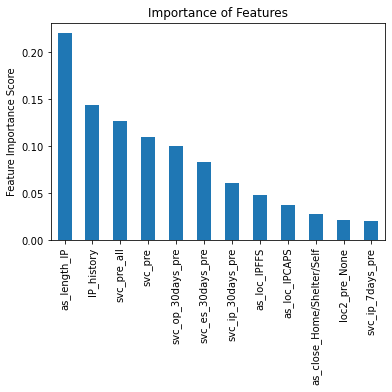

In [39]:
feat_imp = pd.Series(new.feature_importances_, index=Xtrainb.columns).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')


In [40]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
lr_importances = pd.Series(model_cvsb['logistic'].coef_[0], index=Xtrainb.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvsb['logistic'].coef_[0]), index=Xtrainb.columns, name = 'LR')
print(lr_importances)

Fitting models.
naive bayes... Time elapsed  0:00:00.034000
done
knn... Time elapsed  0:00:00.831005
done
logistic... Time elapsed  0:00:00.088000
done
mlp-nn... Time elapsed  0:00:08.059993
done
decision tree... Time elapsed  0:00:00.251001
done
random forest... Time elapsed  0:00:05.321006
done
gbm... Time elapsed  0:00:05.024007
done
Done.

as_length_IP                 -1.110309
IP_history                    2.668832
svc_pre_all                   0.384198
svc_pre                      -0.631956
svc_op_30days_pre             1.905521
svc_es_30days_pre             1.157350
svc_ip_7days_pre             -3.341092
svc_ip_30days_pre             4.100226
as_loc_IPCAPS                -1.236845
as_loc_IPFFS                 -1.385462
as_close_Home/Shelter/Self   -0.243241
loc2_pre_None                -0.428993
Name: LR, dtype: float64


max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.\
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.\
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.\
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.\
scale_pos_weight = 1: Because of high class imbalance.

### Archive codes

In [ ]:
'''
# impute missing values of categorical features with the most frequent object
for col in categorical_features:
    df[col].fillna(df[col].value_counts().index[0], inplace=True)
'''

In [ ]:
'''
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
'''

In [ ]:
'''
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=4, 
                    scale_pos_weight=1, random_state=SEED)
grid_search = GridSearchCV(xgb, param_grid = parameters, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
grid_search.fit(Xtrainb_scaled, ytrain)

# retrieve the best parameter set from grid search
print("\nGrid Search Best parameters set :")
print(grid_search.best_params_)
print("\nBest score: %0.3f" % grid_search.best_score_)
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

'''

In [ ]:
'''
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")
    
def report_models(S, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        report = classification_report(y, S.loc[:, m])
        print(report)
    print("Done.\n")

'''

In [ ]:
'''
param3 = {
   'min_samples_split':[4,8,10,20,40,60,80,100], 
    'min_samples_leaf':[1,3,5,7,9]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), 
            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

'''